In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from custom import custom_funcs as cf
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Cliques, Triangles and Squares

Let's pose a problem: If A knows B and B knows C, would it be probable that A knows C as well? In a graph involving just these three individuals, it may look as such:

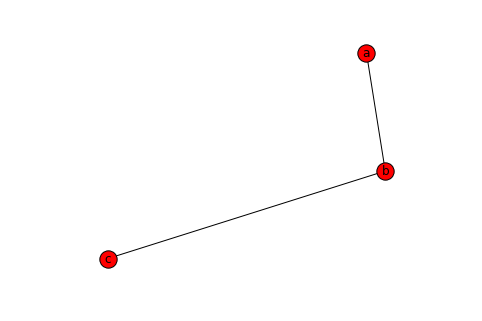

In [2]:
G = nx.Graph()
G.add_nodes_from(['a', 'b', 'c'])
G.add_edges_from([('a','b'), ('b', 'c')])
nx.draw(G, with_labels=True)

Let's think of another problem: If A knows B, B knows C, C knows D and D knows A, is it likely that A knows C and B knows D? How would this look like?

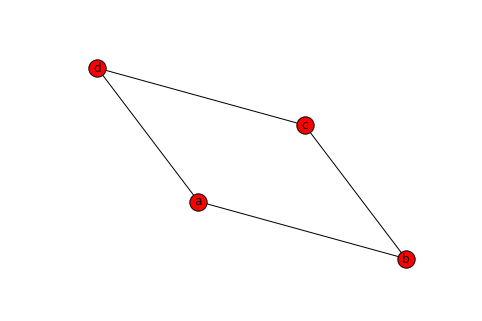

In [3]:
G.add_node('d')
G.add_edge('c', 'd')
G.add_edge('d', 'a')
nx.draw(G, with_labels=True)

The set of relationships involving A, B and C, if closed, involves a triangle in the graph. The set of relationships that also include D form a square.

You may have observed that social networks (LinkedIn, Facebook, Twitter etc.) have friend recommendation systems. How exactly do they work? Apart from analyzing other variables, closing triangles is one of the core ideas behind the system. A knows B and B knows C, then A probably knows C as well.

If all of the triangles in the two small-scale networks were closed, then the graph would have represented **cliques**, in which everybody within that subgraph knows one another.

In this section, we will attempt to answer the following questions:

1. Can we identify cliques?
2. Can we identify *potential* cliques that aren't currently present in the network?
3. Can we model the probability that two unconnected individuals know one another?

## Load Data

As usual, let's start by loading some network data. This time round, we have a [physician trust](http://konect.uni-koblenz.de/networks/moreno_innovation) network, but slightly modified such that it is undirected rather than directed.

> This directed network captures innovation spread among 246 physicians in for towns in Illinois, Peoria, Bloomington, Quincy and Galesburg. The data was collected in 1966. A node represents a physician and an edge between two physicians shows that the left physician told that the righ physician is his friend or that he turns to the right physician if he needs advice or is interested in a discussion. There always only exists one edge between two nodes even if more than one of the listed conditions are true.

In [4]:
# Load the network.
G = cf.load_physicians_network()

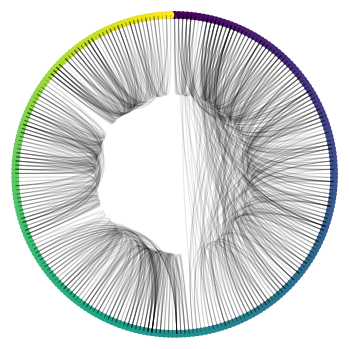

In [5]:
# Make a Circos plot of the graph
import numpy as np
from circos import CircosPlot

nodes = sorted(G.nodes())
edges = G.edges()
edgeprops = dict(alpha=0.1)
nodecolor = plt.cm.viridis(np.arange(len(nodes)) / len(nodes)) 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
c = CircosPlot(nodes, edges, radius=10, ax=ax, edgeprops=edgeprops, nodecolor=nodecolor)
c.draw()

### Question

What can you infer about the structure of the graph from the Circos plot?

My answer: The structure is interesting. The graph looks like the physician trust network is comprised of discrete subnetworks.

## Cliques

In a social network, cliques are groups of people in which everybody knows everybody. Triangles are a simple example of cliques. Let's try implementing a simple algorithm that finds out whether a node is present in a triangle or not.

The core idea is that if a node is present in a triangle, then its neighbors' neighbors' neighbors should include itself.

In [ ]:
# Example code that shouldn't be too hard to follow.
def in_triangle(G, node):
    neighbors1 = G.neighbors(node)
    neighbors2 = []
    for n in neighbors1:
        neighbors = G.neighbors(n)
        if node in neighbors2:
            neighbors2.remove(node)
        neighbors2.extend(G.neighbors(n))
    
    neighbors3 = []
    for n in neighbors2:
        neighbors = G.neighbors(n)
        neighbors3.extend(G.neighbors(n))
        
    return node in neighbors3

in_triangle(G, 3)

In reality, NetworkX already has a function that *counts* the number of triangles that any given node is involved in. This is probably more useful than knowing whether a node is present in a triangle or not, but the above code was simply for practice.

In [ ]:
nx.triangles(G, 3)

### Exercise

Can you write a function that takes in one node and its associated graph as an input, and returns a list or set of itself + all other nodes that it is in a triangle relationship with?

Hint: The neighbor of my neighbor should also be my neighbor, then the three of us are in a triangle relationship.

Hint: Python Sets may be of great use for this problem. https://docs.python.org/2/library/stdtypes.html#set

Verify your answer by drawing out the subgraph composed of those nodes.

In [17]:
# Possible answer
def get_triangles(G, node):
    neighbors1 = set(G.neighbors(node))
    triangle_nodes = set()
    """
    Fill in the rest of the code below.
    """
    triangle_paths = []
    
    for n in neighbors1:
        for n2 in set(G.neighbors(node)):
            triangle_paths.extend([n,n2])
    
    for i in range[1:len(triangle_paths)]:
        for n3 in set(G.neighbors(triangle_paths[i][1])):
            triangle_paths[i].extend('n3')
            
    print (triangle_paths)
    
    return triangle_nodes

# Verify your answer with the following funciton call. Should return:
# {1, 2, 3, 6, 23}
get_triangles(G, 3)

TypeError: 'type' object is not subscriptable

In [ ]:
# Then, draw out those nodes.
nx.draw(G.subgraph(get_triangles(G, 3)), with_labels=True)

In [ ]:
# Compare for yourself that those are the only triangles that node 3 is involved in.
neighbors3 = G.neighbors(3)
neighbors3.append(3)
nx.draw(G.subgraph(neighbors3), with_labels=True)

# Friend Recommendation: Open Triangles

Now that we have some code that identifies closed triangles, we might want to see if we can do some friend recommendations by looking for open triangles.

Open triangles are like those that we described earlier on - A knows B and B knows C, but C's relationship with A isn't captured in the graph. 

### Exercise
Can you write a function that identifies, for a given node, the other two nodes that it is involved with in an open triangle, if there is one? 

Hint: You may still want to stick with set operations. Suppose we have the A-B-C triangle. If there are neighbors of C that are also neighbors of B, then those neighbors are in a triangle with B and C; consequently, if there are nodes for which C's neighbors do not overlap with B's neighbors, then those nodes are in an open triangle. The final implementation should include some conditions, and probably won't be as simple as described above.

In [46]:
# Possible Answer, credit Justin Zabilansky (MIT) for help on this.
def get_open_triangles(G, node):
    """
    There are many ways to represent this. One may choose to represent only the nodes involved 
    in an open triangle; this is not the approach taken here.
    
    Rather, we have a code that explicitly enumrates every open triangle present.
    """
    open_triangle_nodes = []
    neighbors = set(G.neighbors(node))
    
    
    for n1 in neighbors:
        for n2 in neighbors:
            if(n1 != n2):
                if (node, n2) not in set(G.edges()):
                   open_triangle_nodes.append((node,n1,n2))
    print (open_triangle_nodes)    
        
#    for n1 in neighbors: 
#        neighbors2 = set(G.neighbors(n1))
#        new_neighbors = neighbors2 - neighbors
#        new_neighbors.remove(node)
#        for n2 in new_neighbors:
#            open_triangle_nodes.append((node,n1,n2))
        
    return open_triangle_nodes

print (len(get_open_triangles(G, 3)))

[(3, 67, 1), (3, 101, 1), (3, 9, 1), (3, 41, 1), (3, 42, 1), (3, 11, 1), (3, 112, 1), (3, 91, 1)]
8


[(3, 67, 1), (3, 101, 1), (3, 9, 1), (3, 41, 1), (3, 42, 1), (3, 11, 1), (3, 112, 1), (3, 91, 1)]
[(3, 67, 1), (3, 101, 1), (3, 9, 1), (3, 41, 1), (3, 42, 1), (3, 11, 1), (3, 112, 1), (3, 91, 1)]
[(3, 67, 1), (3, 101, 1), (3, 9, 1), (3, 41, 1), (3, 42, 1), (3, 11, 1), (3, 112, 1), (3, 91, 1)]
[(3, 67, 1), (3, 101, 1), (3, 9, 1), (3, 41, 1), (3, 42, 1), (3, 11, 1), (3, 112, 1), (3, 91, 1)]


8

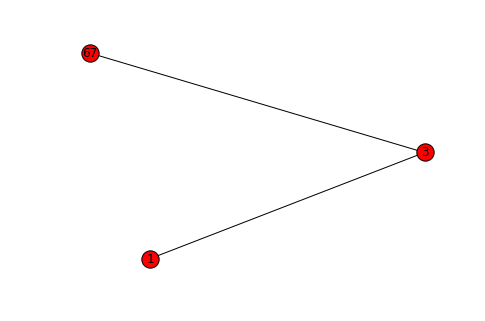

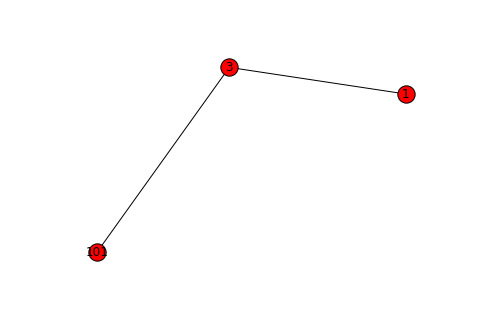

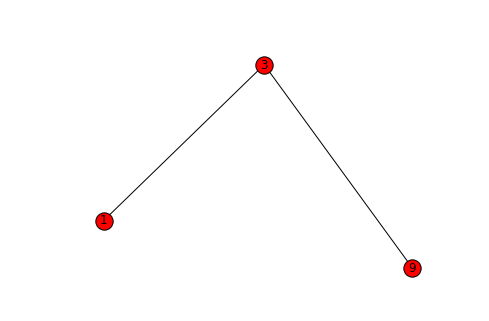

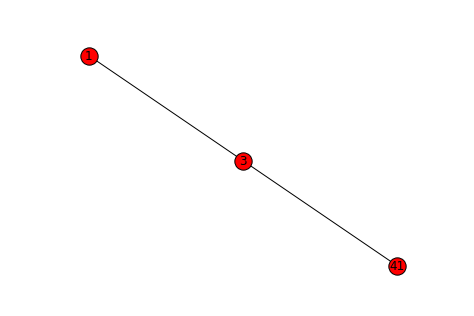

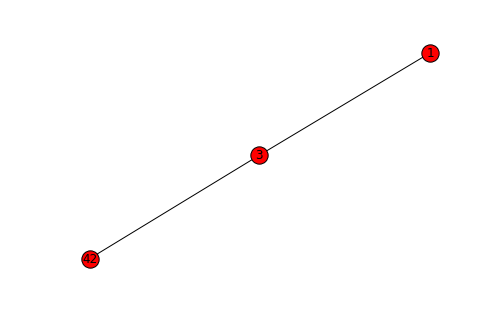

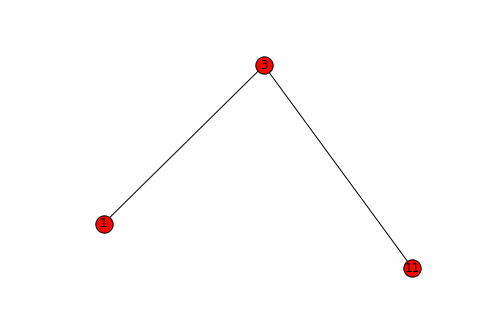

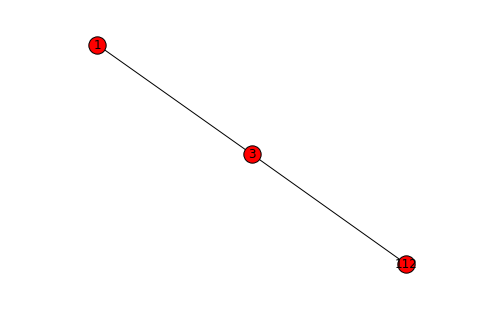

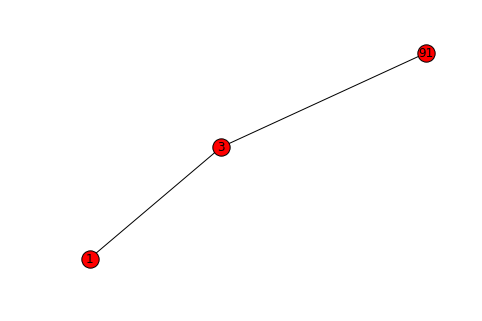

In [48]:
# # Uncomment the following code if you want to draw out each of the triplets.
nodes = get_open_triangles(G, 3)
for i, triplet in enumerate(nodes):
     fig = plt.figure(i)
     nx.draw(G.subgraph(triplet), with_labels=True)
print(get_open_triangles(G, 3))
len(get_open_triangles(G, 3))

If you remember the previous section on hubs and paths, you will note that node 19 was involved in a lot of open triangles.

Triangle closure is also the core idea behind social networks' friend recommendation systems; of course, it's definitely more complicated than what we've implemented here.

## Cliques

We have figured out how to find triangles. Now, let's find out what **cliques** are present in the network. Recall: what is the definition of a clique?

- NetworkX has a [clique-finding](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.clique.find_cliques.html) algorithm implemented.
- This algorithm finds all maximally-sized cliques for a given node.
- Note that maximal cliques of size `n` include all cliques of `size < n`

In [ ]:
list(nx.find_cliques(G))

### Exercise

This should allow us to find all n-sized maximal cliques. Try writing a function `maximal_cliques_of_size(size, G)` that implements this.

In [ ]:
def maximal_cliqes_of_size(size, G):
    return ______________________

maximal_cliqes_of_size(2, G)

## Connected Components

From [Wikipedia](https://en.wikipedia.org/wiki/Connected_component_%28graph_theory%29):

> In graph theory, a connected component (or just component) of an undirected graph is a subgraph in which any two vertices are connected to each other by paths, and which is connected to no additional vertices in the supergraph.

NetworkX also implements a [function](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.components.connected.connected_component_subgraphs.html) that identifies connected component subgraphs.

Remember how based on the Circos plot above, we had this hypothesis that the physician trust network may be divided into subgraphs. Let's check that, and see if we can redraw the Circos visualization.

In [ ]:
ccsubgraphs = list(nx.connected_component_subgraphs(G))
len(ccsubgraphs)

### Exercise

Play a bit with the Circos API. Can you colour the nodes by their subgraph identifier?

In [ ]:
# Start by labelling each node in the master graph G by some number
# that represents the subgraph that contains the node.
for i, g in enumerate(_____________):
    
        
# Then, pass in a list of nodecolors that correspond to the node order.
node_cmap = {0: 'red', 1:'blue', 2: 'green', 3:'yellow'}
nodecolor = [__________________________________________]

nodes = sorted(G.nodes())
edges = G.edges()
edgeprops = dict(alpha=0.1)

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
c = CircosPlot(nodes, edges, radius=10, ax=ax, fig=fig, edgeprops=edgeprops, nodecolor=nodecolor)
c.draw()
plt.savefig('images/physicians.png', dpi=300)

And "admire" the division of the US congress over the years...

![Congress Voting Patterns](https://img.washingtonpost.com/wp-apps/imrs.php?src=https://img.washingtonpost.com/blogs/wonkblog/files/2015/04/journal.pone_.0123507.g002.png&w=1484)